In [1]:
# standard DS imports
import pandas as pd
import numpy as np

# viz and stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as px
from scipy import stats

# for feature selection verification and evaluation 
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

# local functions
import wrangle
import morgan_explore
import morgan_model

In [2]:
zil = wrangle.acquire_zillow()

In [3]:
zil = wrangle.prepare_zillow(zil)

In [4]:
# zil['living_space'] = zil.area - zil.baths*60 - zil.beds*200

In [5]:
# zil['price_sqft'] = zil.tax_value/zil.area

In [6]:
train, val, test = wrangle.split_data(zil)

In [7]:
train.shape, val.shape, test.shape

((30418, 41), (10140, 41), (10140, 41))

In [8]:
train.head()

,basement_sqft,baths,beds,bathnbed,decktype,area,area12,county,fireplace,fullbath,...,taxes,tax_delq_flag,tax_delq_year,census,logerror,transactiondate,construction_type,landuse_desc,living_space,price_sqft
22304,0.0,2.0,3.0,2.0,0.0,2053.0,2053.0,6037.0,0.0,2.0,...,3512.57,N,99999.0,6.037901e+13,0.080855,2017-05-05,None,Single Family Residential,1333.0,115.063809
8815,0.0,3.0,4.0,3.0,0.0,2996.0,2996.0,6037.0,0.0,3.0,...,15005.62,N,99999.0,6.037272e+13,-0.084714,2017-02-28,None,Single Family Residential,2016.0,416.372163
25011,0.0,3.0,4.0,3.0,0.0,2003.0,2003.0,6037.0,0.0,3.0,...,7535.17,N,99999.0,6.037621e+13,0.019131,2017-05-18,None,Single Family Residential,1023.0,333.059411
44006,0.0,2.0,3.0,2.0,0.0,1627.0,1627.0,6111.0,1.0,2.0,...,4348.94,N,99999.0,6.111001e+13,-0.032695,2017-08-10,None,Single Family Residential,907.0,254.505224
27970,0.0,2.5,4.0,2.5,0.0,2207.0,2207.0,6059.0,1.0,2.0,...,7937.82,Y,15.0,6.059076e+13,0.054198,2017-05-31,None,Single Family Residential,1257.0,319.058903


In [9]:
train.columns

Index(['basement_sqft', 'baths', 'beds', 'bathnbed', 'decktype', 'area',
       'area12', 'county', 'fireplace', 'fullbath', 'hottub_or_spa', 'lat',
       'long', 'lotsize', 'pool', 'pool10', 'pool2', 'pool7', 'landuse_code',
       'raw_census', 'city_id', 'county_id', 'zip_id', 'rooms',
       'threequarterbnb', 'year_built', 'fireplace_flag', 'structure_value',
       'tax_value', 'assessment_year', 'land_value', 'taxes', 'tax_delq_flag',
       'tax_delq_year', 'census', 'logerror', 'transactiondate',
       'construction_type', 'landuse_desc', 'living_space', 'price_sqft'],
      dtype='object')

In [10]:
cols = ['baths','beds','living_space', 'city_id','tax_value', 'year_built', 'price_sqft']
train_scaled, val_scaled, test_scaled = wrangle.scale_data(train, val, test, cols)

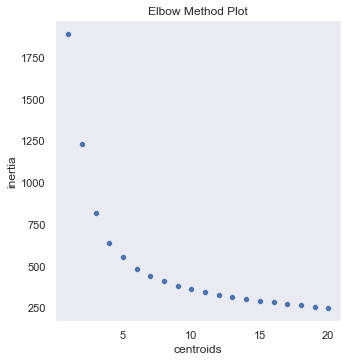

In [11]:
morgan_model.run_kmeans(train_scaled[['baths','beds','living_space', 'city_id','tax_value', 'year_built', 'price_sqft']], 20)

In [12]:
km = KMeans(n_clusters = 4)
km.fit(train_scaled[['baths','beds','living_space', 'city_id','tax_value', 'year_built']])
train['cluster'] = km.predict(train_scaled[['baths','beds','living_space', 'city_id','tax_value', 'year_built']])
val['cluster'] = km.predict(val_scaled[['baths','beds','living_space', 'city_id','tax_value', 'year_built']])
test['cluster'] = km.predict(test_scaled[['baths','beds','living_space', 'city_id','tax_value', 'year_built']])

<Figure size 864x576 with 0 Axes>

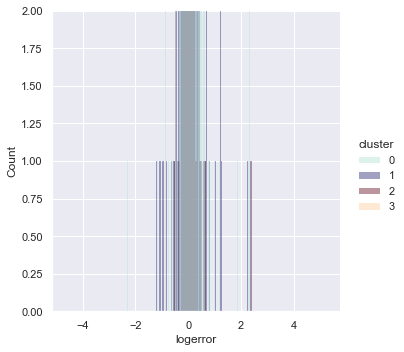

In [13]:
plt.figure(figsize=(12,8))
sns.displot(data=train, x='logerror', hue='cluster', palette='icefire')
plt.ylim(0,2)
plt.show()

<AxesSubplot:xlabel='lat', ylabel='long'>

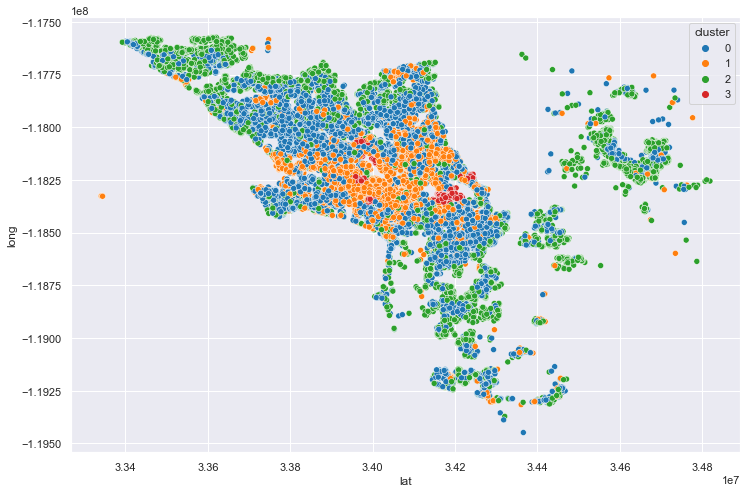

In [14]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=train, x='lat', y='long', hue='cluster', palette='tab10')

In [15]:
train.cluster.value_counts()

0    15477
2     8224
1     6223
3      494
Name: cluster, dtype: int64

In [16]:
train.logerror.std()

0.17747613064295908

<Figure size 864x576 with 0 Axes>

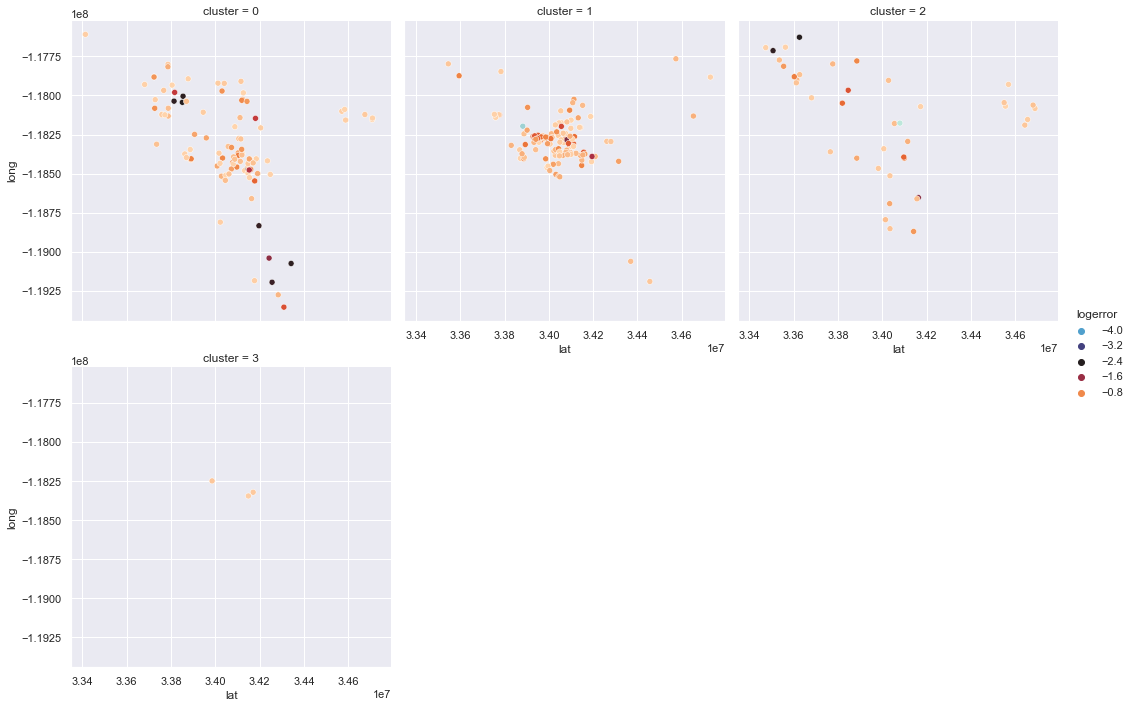

In [17]:
plt.figure(figsize=(12,8))
sns.relplot(data=train[(train.logerror < (train.logerror.mean()-2*train.logerror.std()))], x='lat', y='long', hue='logerror', palette='icefire', col='cluster', col_wrap=3)

clusters 0 1 and 2 have all the homes with error

In [18]:
train.columns

Index(['basement_sqft', 'baths', 'beds', 'bathnbed', 'decktype', 'area',
       'area12', 'county', 'fireplace', 'fullbath', 'hottub_or_spa', 'lat',
       'long', 'lotsize', 'pool', 'pool10', 'pool2', 'pool7', 'landuse_code',
       'raw_census', 'city_id', 'county_id', 'zip_id', 'rooms',
       'threequarterbnb', 'year_built', 'fireplace_flag', 'structure_value',
       'tax_value', 'assessment_year', 'land_value', 'taxes', 'tax_delq_flag',
       'tax_delq_year', 'census', 'logerror', 'transactiondate',
       'construction_type', 'landuse_desc', 'living_space', 'price_sqft',
       'cluster'],
      dtype='object')

In [19]:
value_clusters = train[['structure_value','tax_value', 'land_value', 'taxes', 'logerror', 'price_sqft']]
cols = ['structure_value','tax_value', 'land_value', 'taxes', 'price_sqft']

In [20]:
from sklearn.preprocessing import MinMaxScaler 

In [21]:
value_scaled = value_clusters.copy()
scaler = MinMaxScaler()
scaler.fit(value_clusters[cols])
value_scaled[cols] = pd.DataFrame(scaler.transform(value_clusters[cols]),
                                               columns = value_clusters[cols].columns.values).set_index([value_clusters.index.values])

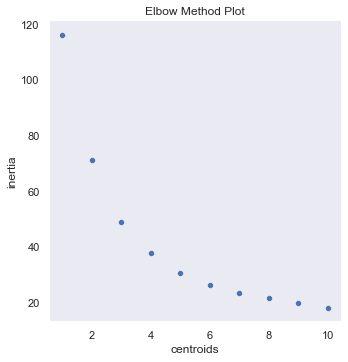

In [22]:
morgan_model.run_kmeans(value_scaled[cols], 10)

In [23]:
km = KMeans(n_clusters = 3)
km.fit(value_scaled[['structure_value','tax_value', 'land_value', 'taxes', 'price_sqft']])
value_clusters['cluster'] = km.predict(value_scaled[['structure_value','tax_value', 'land_value', 'taxes', 'price_sqft']])
# test['cluster'] = km.predict(test_scaled[['baths','beds','area', 'city_id','tax_value', 'year_built']])

/var/folders/tg/htdzmdmj40vgs24scqz284xm0000gn/T/ipykernel_77438/2642429049.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  value_clusters['cluster'] = km.predict(value_scaled[['structure_value','tax_value', 'land_value', 'taxes', 'price_sqft']])


<AxesSubplot:xlabel='logerror', ylabel='tax_value'>

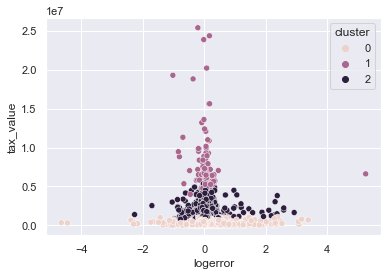

In [24]:
sns.scatterplot(data=value_clusters, x='logerror', y='tax_value', hue='cluster')

clusters 0  might be helpful to isolate since they have a wide spread of error

In [25]:
train['value_clusters'] = value_clusters.cluster
train_scaled['value_clusters'] = value_clusters.cluster

In [26]:
train.columns

Index(['basement_sqft', 'baths', 'beds', 'bathnbed', 'decktype', 'area',
       'area12', 'county', 'fireplace', 'fullbath', 'hottub_or_spa', 'lat',
       'long', 'lotsize', 'pool', 'pool10', 'pool2', 'pool7', 'landuse_code',
       'raw_census', 'city_id', 'county_id', 'zip_id', 'rooms',
       'threequarterbnb', 'year_built', 'fireplace_flag', 'structure_value',
       'tax_value', 'assessment_year', 'land_value', 'taxes', 'tax_delq_flag',
       'tax_delq_year', 'census', 'logerror', 'transactiondate',
       'construction_type', 'landuse_desc', 'living_space', 'price_sqft',
       'cluster', 'value_clusters'],
      dtype='object')

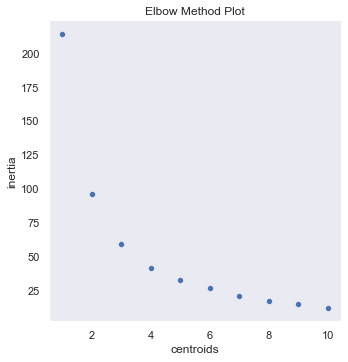

In [27]:
size_clusters = train[['basement_sqft','area', 'area12', 'lotsize','living_space', 'logerror']]
cols = ['basement_sqft','area', 'area12', 'lotsize','living_space']
size_scaled = size_clusters.copy()
scaler = MinMaxScaler()
scaler.fit(size_clusters[cols])
size_scaled[cols] = pd.DataFrame(scaler.transform(size_clusters[cols]),
                                               columns = size_clusters[cols].columns.values).set_index([size_clusters.index.values])
morgan_model.run_kmeans(size_scaled[cols], 10)

In [28]:
km = KMeans(n_clusters = 3)
km.fit(size_scaled[cols])
size_clusters['cluster'] = km.predict(size_scaled[cols])

/var/folders/tg/htdzmdmj40vgs24scqz284xm0000gn/T/ipykernel_77438/509432908.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  size_clusters['cluster'] = km.predict(size_scaled[cols])


<AxesSubplot:xlabel='logerror', ylabel='area'>

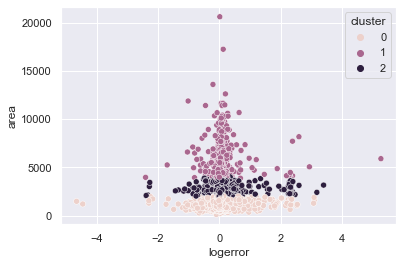

In [29]:
sns.scatterplot(data=size_clusters, x='logerror', y='area', hue='cluster')

might be good to isolate clusters 1 and 2.

In [30]:
train['size_clusters'] = size_clusters.cluster
train_scaled['size_clusters'] = size_clusters.cluster

<AxesSubplot:xlabel='lat', ylabel='long'>

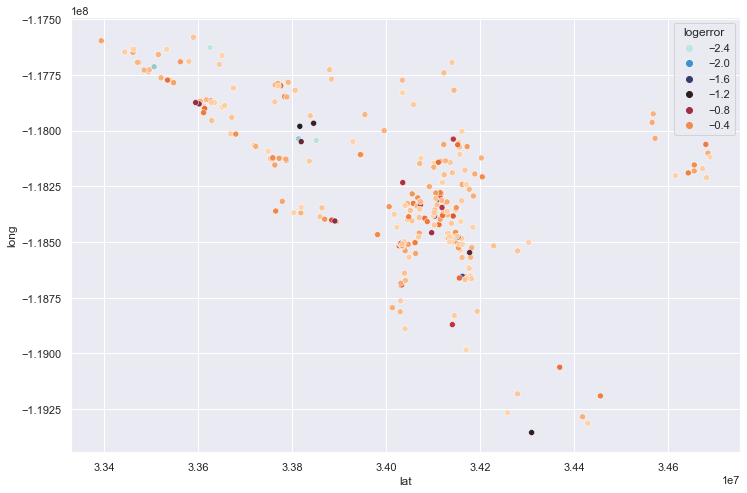

In [31]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=train[((train.size_clusters == 2)|(train.size_clusters == 1))&((train.value_clusters == 0)|(train.value_clusters == 2))&(train.logerror < -.17)],
                y='long', 
                x='lat',
               hue='logerror',
               palette = 'icefire')

In [32]:
train.size_clusters.value_counts()

0    20445
2     8743
1     1230
Name: size_clusters, dtype: int64

In [33]:
dummies = pd.get_dummies(train.cluster, columns=['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3'])
dummie = pd.get_dummies(train.value_clusters, columns=['value_0', 'value_1', 'value_2'])
dum = pd.get_dummies(train.size_clusters, columns=['size_0', 'size_1', 'size_2'])

train = pd.concat([train_scaled, dummies, dummie, dum], axis=1)

In [34]:
train.columns.tolist()

['basement_sqft',
 'baths',
 'beds',
 'bathnbed',
 'decktype',
 'area',
 'area12',
 'county',
 'fireplace',
 'fullbath',
 'hottub_or_spa',
 'lat',
 'long',
 'lotsize',
 'pool',
 'pool10',
 'pool2',
 'pool7',
 'landuse_code',
 'raw_census',
 'city_id',
 'county_id',
 'zip_id',
 'rooms',
 'threequarterbnb',
 'year_built',
 'fireplace_flag',
 'structure_value',
 'tax_value',
 'assessment_year',
 'land_value',
 'taxes',
 'tax_delq_flag',
 'tax_delq_year',
 'census',
 'logerror',
 'transactiondate',
 'construction_type',
 'landuse_desc',
 'living_space',
 'price_sqft',
 'value_clusters',
 'size_clusters',
 0,
 1,
 2,
 3,
 0,
 1,
 2,
 0,
 1,
 2]

In [35]:
train.columns = ['basement_sqft',
 'baths',
 'beds',
 'bathnbed',
 'decktype',
 'area',
 'area12',
 'county',
 'fireplace',
 'fullbath',
 'hottub_or_spa',
 'lat',
 'long',
 'lotsize',
 'pool',
 'pool10',
 'pool2',
 'pool7',
 'landuse_code',
 'raw_census',
 'city_id',
 'county_id',
 'zip_id',
 'rooms',
 'threequarterbnb',
 'year_built',
 'fireplace_flag',
 'structure_value',
 'tax_value',
 'assessment_year',
 'land_value',
 'taxes',
 'tax_delq_flag',
 'tax_delq_year',
 'census',
 'logerror',
 'transactiondate',
 'construction_type',
 'landuse_desc',
 'living_space',
 'price_sqft',
 'value_clusters',
 'size_clusters','cluster_0', 'cluster_1', 'cluster_2', 'cluster_3',
'value_0', 'value_1', 'value_2', 'size_0', 'size_1', 'size_2']

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30418 entries, 22304 to 14850
Data columns (total 53 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   basement_sqft      30418 non-null  float64
 1   baths              30418 non-null  float64
 2   beds               30418 non-null  float64
 3   bathnbed           30418 non-null  float64
 4   decktype           30418 non-null  float64
 5   area               30418 non-null  float64
 6   area12             30418 non-null  float64
 7   county             30418 non-null  float64
 8   fireplace          30418 non-null  float64
 9   fullbath           30418 non-null  float64
 10  hottub_or_spa      30418 non-null  float64
 11  lat                30418 non-null  float64
 12  long               30418 non-null  float64
 13  lotsize            30418 non-null  float64
 14  pool               30418 non-null  float64
 15  pool10             30418 non-null  float64
 16  pool2             

In [37]:
cols_to_scale = ['baths', 'beds', 'living_space', 'county', 'lat', 'long', 'lotsize', 'pool', 'city_id','year_built', 'tax_value', 'price_sqft',
                'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 
                'value_0', 'value_1', 'value_2',
                'size_0', 'size_1', 'size_2']

train_scaled = train.copy()

# create the scaler and fit it
scaler = MinMaxScaler()
scaler.fit(train[cols_to_scale])

# use the scaler to scale the data and resave
train_scaled[cols_to_scale] = pd.DataFrame(scaler.transform(train[cols_to_scale]),
                                           columns = train[cols_to_scale].columns.values).set_index([train.index.values])

In [38]:
train_scaled.head()

,basement_sqft,baths,beds,bathnbed,decktype,area,area12,county,fireplace,fullbath,...,cluster_0,cluster_1,cluster_2,cluster_3,value_0,value_1,value_2,size_0,size_1,size_2
22304,0.0,0.153846,0.272727,2.0,0.0,2053.0,2053.0,0.000000,0.0,2.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8815,0.0,0.230769,0.363636,3.0,0.0,2996.0,2996.0,0.000000,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
25011,0.0,0.230769,0.363636,3.0,0.0,2003.0,2003.0,0.000000,0.0,3.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
44006,0.0,0.153846,0.272727,2.0,0.0,1627.0,1627.0,1.000000,1.0,2.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
27970,0.0,0.192308,0.363636,2.5,0.0,2207.0,2207.0,0.297297,1.0,2.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [39]:
X_train, y_train = train_scaled[['baths', 'beds', 'living_space', 'county', 'lat', 'long', 'lotsize', 'pool', 'city_id','year_built', 'tax_value', 'price_sqft',
                                 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 
                                 'value_0', 'value_1', 'value_2',
                                 'size_0', 'size_1', 'size_2'
                                ]], train.logerror
# X_val, y_val = val[['basement_sqft', 'baths', 'beds', 'area', 'county', 'fireplace', 'hottub_or_spa', 'lat',
#        'long', 'lotsize', 'pool', 'city_id', 'zip_id','year_built', 'tax_value', 'taxes', 'tax_delq_flag',
#        'census',  'cluster', 'value_clusters','size_clusters']], val.logerror
# X_test, y_test = test[['basement_sqft', 'baths', 'beds', 'area', 'county', 'fireplace', 'hottub_or_spa', 'lat',
#        'long', 'lotsize', 'pool', 'city_id', 'zip_id','year_built', 'tax_value', 'taxes', 'tax_delq_flag',
#        'census',  'cluster', 'value_clusters','size_clusters']], test.logerror

In [40]:
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

In [41]:
kbest = SelectKBest(f_regression, k=7)
kbest.fit(X_train, y_train)

print(X_train.columns[kbest.get_support()].tolist())

['baths', 'beds', 'living_space', 'long', 'price_sqft', 'size_0', 'size_1']


In [42]:
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [43]:
y_train = pd.DataFrame(y_train)

# Baseline Model
# run the model
pred_mean = y_train.logerror.mean()
y_train['pred_mean'] = pred_mean
# y_val['pred_mean'] = pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.pred_mean, squared=False)
# rmse_val = mean_squared_error(y_val.value, y_val.pred_mean, squared=False)

# save the results
metrics = pd.DataFrame(data=[{
    'model': 'baseline_mean',
    'rmse_train': rmse_train,
    'r2_train': explained_variance_score(y_train.logerror, y_train.pred_mean)
    # 'rmse_val': rmse_val,
    # 'r2_val': explained_variance_score(y_val.value, y_val.pred_mean)
}])


lm = LinearRegression()
lm.fit(X_train, y_train.logerror)
y_train['pred_lm'] = lm.predict(X_train)
rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lm, squared=False)
# y_val['pred_lm'] = lm.predict(X_val)
# rmse_val = mean_squared_error(y_val.tax_value, y_val.pred_lm, squared=False)
# print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
#       "\nValidation/Out-of-Sample: ", rmse_val)

metrics = metrics.append({
    'model': 'OLS',
    'rmse_train': rmse_train,
    'r2_train': explained_variance_score(y_train.logerror, y_train.pred_lm
    # 'rmse_val': rmse_val,
    # 'r2_val': explained_variance_score(y_val.value, y_val.pred_lars
    )}, ignore_index=True)

# LassoLars Model
# run the model
lars = LassoLars(alpha=1)
lars.fit(X_train, y_train.logerror)
y_train['pred_lars'] = lars.predict(X_train)
rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lars, squared=False)
# y_val['pred_lars'] = lars.predict(X_val)
# rmse_val = mean_squared_error(y_val.value, y_val.pred_lars, squared=False)

# save the results
metrics = metrics.append({
    'model': 'LarsLasso, alpha 1',
    'rmse_train': rmse_train,
    'r2_train': explained_variance_score(y_train.logerror, y_train.pred_lars
    # 'rmse_val': rmse_val,
    # 'r2_val': explained_variance_score(y_val.value, y_val.pred_lars
    )}, ignore_index=True)


# glm = TweedieRegressor(power=1, alpha=0, warm_start=True)
# glm.fit(X_train, y_train.logerror)
# y_train['pred_glm'] = glm.predict(X_train)
# rmse_train = mean_squared_error(y_train.logerror, y_train.pred_glm, squared=False)

# # save the results
# metrics = metrics.append({
#     'model': 'Poisson',
#     'rmse_train': rmse_train,
#     'r2_train': explained_variance_score(y_train.logerror, y_train.pred_glm
#     # 'rmse_val': rmse_val,
#     # 'r2_val': explained_variance_score(y_val.value, y_val.pred_lars
#     )}, ignore_index=True)


# glm = TweedieRegressor(power=2, alpha=0, warm_start=True)
# glm.fit(X_train, y_train.logerror)
# y_train['pred_glm'] = glm.predict(X_train)
# rmse_train = mean_squared_error(y_train.logerror, y_train.pred_glm, squared=False)

# # save the results
# metrics = metrics.append({
#     'model': 'Gamma',
#     'rmse_train': rmse_train,
#     'r2_train': explained_variance_score(y_train.logerror, y_train.pred_glm
#     # 'rmse_val': rmse_val,
#     # 'r2_val': explained_variance_score(y_val.value, y_val.pred_lars
#     )}, ignore_index=True)

# glm = TweedieRegressor(power=3, alpha=0, warm_start=True)
# glm.fit(X_train, y_train.logerror)
# y_train['pred_glm'] = glm.predict(X_train)
# rmse_train = mean_squared_error(y_train.logerror, y_train.pred_glm, squared=False)

# # save the results
# metrics = metrics.append({
#     'model': 'Inverse Gaussian',
#     'rmse_train': rmse_train,
#     'r2_train': explained_variance_score(y_train.logerror, y_train.pred_glm
#     # 'rmse_val': rmse_val,
#     # 'r2_val': explained_variance_score(y_val.value, y_val.pred_lars
#     )}, ignore_index=True)

# Polynomial Models
# set up the model
pf = PolynomialFeatures(degree=2)
X_train_d2 = pf.fit_transform(X_train)
# X_val_d2 = pf.transform(X_val)

# run the model
lm2 = LinearRegression()
lm2.fit(X_train_d2, y_train.logerror)
y_train['pred_lm2'] = lm2.predict(X_train_d2)
rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lm2, squared=False)
# y_val['pred_lm2'] = lm2.predict(X_val_d2)
# rmse_val = mean_squared_error(y_val.value, y_val.pred_lm2, squared=False)

# save the results
metrics = metrics.append({
    'model': 'Quadratic Linear Regression',
    'rmse_train': rmse_train,
    'r2_train': explained_variance_score(y_train.logerror, y_train.pred_lm2)
    # 'rmse_val': rmse_val,
    # 'r2_val': explained_variance_score(y_val.value, y_val.pred_lm2)
}, ignore_index=True)

# set up the model
pf = PolynomialFeatures(degree=3)
X_train_d2 = pf.fit_transform(X_train)
# X_val_d2 = pf.transform(X_val)

# run the model
lm2 = LinearRegression()
lm2.fit(X_train_d2, y_train.logerror)
y_train['pred_lm2'] = lm2.predict(X_train_d2)
rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lm2, squared=False)
# y_val['pred_lm2'] = lm2.predict(X_val_d2)
# rmse_val = mean_squared_error(y_val.value, y_val.pred_lm2, squared=False)

# save the results
metrics = metrics.append({
    'model': 'Cubic Linear Regression',
    'rmse_train': rmse_train,
    'r2_train': explained_variance_score(y_train.logerror, y_train.pred_lm2)
    # 'rmse_val': rmse_val,
    # 'r2_val': explained_variance_score(y_val.value, y_val.pred_lm2)
}, ignore_index=True)

metrics

/var/folders/tg/htdzmdmj40vgs24scqz284xm0000gn/T/ipykernel_77438/985035765.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/var/folders

,model,rmse_train,r2_train
0,baseline_mean,0.177473,0.000000
1,OLS,0.176918,0.006249
2,"LarsLasso, alpha 1",0.177473,0.000000
3,Quadratic Linear Regression,0.175254,0.024848
4,Cubic Linear Regression,0.168282,0.100892
